In [2]:
import torch 
import torch.nn as nn 
import streamlit as st
import numpy as np 
import plotly.graph_objects as go 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

In [20]:
class LogisticRegression:


    def __init__(self ,lower_0, upper_0, sample_size_0, noise_0,lower_1, upper_1, sample_size_1, noise_1,w):

        # Parameters
        self.lower_0 = lower_0
        self.upper_0 = upper_0
        self.sample_size_0 = sample_size_0
        self.noise_0 = noise_0
        self.lower_1 = lower_1
        self.upper_1 = upper_1
        self.sample_size_1 = sample_size_1
        self.noise_1 = noise_1
        self.w = w

        # made by attributes
        self.x0 = torch.linspace(lower_0, upper_0, sample_size_0) + torch.tensor([noise_0])
        self.x1 = torch.linspace(lower_1, upper_1, sample_size_1) - torch.tensor([noise_1])
        self.X = torch.cat((self.x0, self.x1), dim=0)
        self.y = torch.cat((torch.zeros(len(self.x0)), torch.ones(len(self.x1))), dim=0)

        # stand alone 
        self.inter_and_extrapolation = torch.linspace(-3,3,1000)
        self.possible_weights = torch.linspace(-5,25,100)
        self.loss_fn = nn.BCEWithLogitsLoss()



    
    # Data points, sigmoid curve
    def generate_plot(self):
        scatter_class_0 = go.Scatter(
            x=self.x0,
            y=torch.zeros(len(self.x0)),
            mode='markers',
            marker=dict(color='purple'),
            name='class purple'
        )
        scatter_class_1 = go.Scatter(
            x=self.x1,
            y=torch.ones(len(self.x1)),
            mode='markers',
            marker=dict(color='orange'),
            name='class orange'
        )

        non_linear_line = go.Scatter(
            x= self.inter_and_extrapolation,
            y=torch.sigmoid(self.w * self.inter_and_extrapolation),
            mode='lines',
            line={'color': 'rgb(27,158,119)'},
            name='model'
        )


        layout = go.Layout(
            xaxis=dict(
                # range=[-3.1, 3.1],
                title='X',
                zeroline=True,
                zerolinewidth=2,
                zerolinecolor='rgba(205, 200, 193, 0.7)'
            ),
            yaxis=dict(
                # range=[-0.5, 1.5],
                title='Y',
                zeroline=True,
                zerolinewidth=2,
                zerolinecolor='rgba(205, 200, 193, 0.7)'
            ),
            # height=500,
            # width=2600
        )
        figure = go.Figure(data=[scatter_class_0, scatter_class_1, non_linear_line], layout=layout)
        return figure
    
#-----------------------------------
# Math for loss_landscape, loss for classes & confusion matrix 

    def Loss(self):
        L = []

        for weight in self.possible_weights:
            z = weight * self.X
            loss = self.loss_fn(z,self.y)
            L.append(loss)

        L = torch.as_tensor(L)
        secret_weight = self.possible_weights[torch.argmin(L)]

        return L
    
    # l_class_0 , l_class_1 , l_class_total 
    def loss_per_class(self):
        loss_class_0 = torch.mean(-torch.log(1-torch.sigmoid(self.w * self.x0)))
        loss_class_1 =  torch.mean(-torch.log(torch.sigmoid(self.w * self.x1)))
        loss_class_0_and_1 = (loss_class_0 + loss_class_1)/2

        return loss_class_0,loss_class_1,loss_class_0_and_1
    
    # confusion matrix 
    def make_predictions(self,threeshold=0.5):
        with torch.no_grad():
            prob = torch.sigmoid(self.w * self.X)
            pred = (prob>threeshold).float()
            cm = confusion_matrix(self.y,pred,labels=[1,0])
            disp = ConfusionMatrixDisplay(cm,display_labels=['orange','purple'])
            
            disp.plot()

        return plt.gcf()
#-------------------------------------

    def loss_landscape(self,L):
        
        # landscape
            loss_landscape = go.Scatter(
                    x = self.possible_weights,
                    y = L,
                    mode = 'lines',
                    line = dict(color='pink'),
                    name ='Loss function landscape'
                )

            # global
            Global_minima = go.Scatter(
                x = (self.possible_weights[torch.argmin(L)],),      # secret weight [The weight that yeilds minimum loss ; Diamond]
                y = (torch.min(L),),
                mode = 'markers',
                marker = dict(color='yellow',size=10,symbol='diamond'),
                name = 'Global minima'
            )


            # ball
            z = self.w * self.X     #forward pass
            loss = self.loss_fn(z,self.y)

            ball = go.Scatter(
                    x = (self.w,),
                    y = (loss,),
                    mode = 'markers',
                    marker= dict(color='red'),
                    name = 'loss'
            )

            layout = go.Layout(
                    xaxis = dict(title='w',
                                # range = [-8,25],
                                zeroline = True,
                                zerolinewidth = 2,
                                zerolinecolor = 'rgba(205, 200, 193, 0.7)'),

                    yaxis = dict(title='L',
                                # range=[0,1.6],
                                zeroline = True,
                                zerolinewidth = 2,
                                zerolinecolor = 'rgba(205, 200, 193, 0.7)')
                )


            figure = go.Figure(data = [loss_landscape,Global_minima,ball],layout=layout)
            
            return figure

In [21]:
w_val = 2.0


data = LogisticRegression(lower_0 = -2,upper_0 = 0, sample_size_0 = 8,noise_0 = 0.2,
                                  lower_1 = 0, upper_1 = 2, sample_size_1 = 8, noise_1 = 0.2,w = w_val)

In [22]:
data.Loss() # third

tensor([4.2511, 4.0079, 3.7656, 3.5241, 3.2836, 3.0444, 2.8068, 2.5713, 2.3383,
        2.1088, 1.8839, 1.6650, 1.4542, 1.2545, 1.0691, 0.9021, 0.7568, 0.6356,
        0.5384, 0.4631, 0.4060, 0.3633, 0.3316, 0.3081, 0.2907, 0.2777, 0.2682,
        0.2614, 0.2565, 0.2533, 0.2513, 0.2504, 0.2504, 0.2511, 0.2523, 0.2542,
        0.2565, 0.2591, 0.2622, 0.2655, 0.2691, 0.2730, 0.2771, 0.2814, 0.2859,
        0.2905, 0.2954, 0.3003, 0.3054, 0.3106, 0.3160, 0.3214, 0.3269, 0.3326,
        0.3383, 0.3441, 0.3500, 0.3559, 0.3619, 0.3680, 0.3741, 0.3803, 0.3866,
        0.3929, 0.3992, 0.4056, 0.4121, 0.4185, 0.4251, 0.4316, 0.4382, 0.4448,
        0.4515, 0.4582, 0.4649, 0.4716, 0.4784, 0.4852, 0.4920, 0.4989, 0.5058,
        0.5127, 0.5196, 0.5265, 0.5335, 0.5404, 0.5474, 0.5544, 0.5615, 0.5685,
        0.5756, 0.5826, 0.5897, 0.5968, 0.6040, 0.6111, 0.6182, 0.6254, 0.6325,
        0.6397])

In [23]:
figure_1 = data.generate_plot()
figure_1

In [24]:
L = data.Loss() # fifth
loss_class_0,loss_class_1,loss_class_0_and_1 = data.loss_per_class()

In [25]:
figure_2 = data.loss_landscape(L)
figure_2

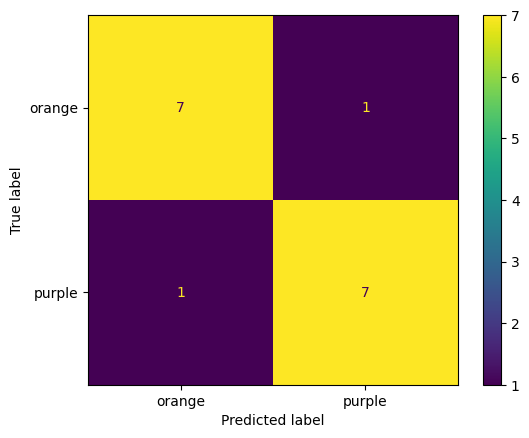

In [26]:
fig = data.make_predictions()

In [34]:
image = go.Scatter(
  x = torch.linspace(-1,1,10),
  y = torch.full((10,),0.5),
  mode = 'lines',
  line = dict(dash='dash')
)

figure = go.Figure(data = image)
figure